<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


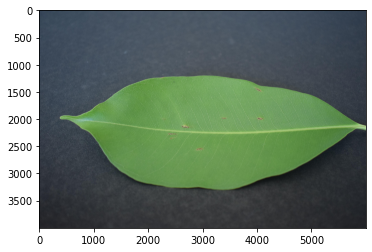

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

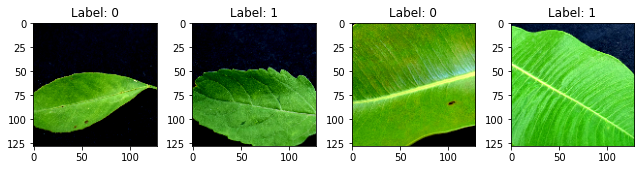

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:14] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:16] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.284290898669015 samples/sec                   batch loss = 1.0069801807403564 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2665852434791367 samples/sec                   batch loss = 0.823584258556366 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2601795159957438 samples/sec                   batch loss = 0.5323783159255981 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.293882544710366 samples/sec                   batch loss = 1.164305329322815 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2728916490824707 samples/sec                   batch loss = 0.23033589124679565 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2954634884296994 samples/sec                   batch loss = 1.029813528060913 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.2961743917341342 samples/sec                   batch loss = 0.43156710267066956 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2953446636378263 samples/sec                   batch loss = 1.2058738470077515 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2988016682539243 samples/sec                   batch loss = 0.5567963123321533 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.3074872378045284 samples/sec                   batch loss = 0.9588271379470825 | accuracy = 0.545


Epoch[1] Batch[55] Speed: 1.3000952760661795 samples/sec                   batch loss = 0.3962353765964508 | accuracy = 0.55


Epoch[1] Batch[60] Speed: 1.2925489828694203 samples/sec                   batch loss = 0.7126172184944153 | accuracy = 0.5458333333333333


Epoch[1] Batch[65] Speed: 1.2948391018931944 samples/sec                   batch loss = 0.476382851600647 | accuracy = 0.5576923076923077


Epoch[1] Batch[70] Speed: 1.2893505259893738 samples/sec                   batch loss = 1.166567325592041 | accuracy = 0.5535714285714286


Epoch[1] Batch[75] Speed: 1.2947877380387256 samples/sec                   batch loss = 0.3124217092990875 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.2979700804611947 samples/sec                   batch loss = 0.31478598713874817 | accuracy = 0.5875


Epoch[1] Batch[85] Speed: 1.2940221604515916 samples/sec                   batch loss = 0.5506406426429749 | accuracy = 0.5911764705882353


Epoch[1] Batch[90] Speed: 1.3035224176630336 samples/sec                   batch loss = 0.33791613578796387 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.297371667258494 samples/sec                   batch loss = 0.6301065683364868 | accuracy = 0.6052631578947368


Epoch[1] Batch[100] Speed: 1.304667464164877 samples/sec                   batch loss = 0.18957652151584625 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.309682997095659 samples/sec                   batch loss = 0.4913090169429779 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.3033981608315288 samples/sec                   batch loss = 0.2980484366416931 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.300532663476293 samples/sec                   batch loss = 0.6313458681106567 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2915760180893758 samples/sec                   batch loss = 1.1119935512542725 | accuracy = 0.63125


Epoch[1] Batch[125] Speed: 1.296711063074516 samples/sec                   batch loss = 0.5849362015724182 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.297254598614398 samples/sec                   batch loss = 0.42621946334838867 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.291995055104108 samples/sec                   batch loss = 0.5165139436721802 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.293314014172387 samples/sec                   batch loss = 0.3341188132762909 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.2915260064354535 samples/sec                   batch loss = 0.8056578040122986 | accuracy = 0.6293103448275862


Epoch[1] Batch[150] Speed: 1.300760241426428 samples/sec                   batch loss = 0.4802069067955017 | accuracy = 0.63


Epoch[1] Batch[155] Speed: 1.2916994232505827 samples/sec                   batch loss = 0.6820151209831238 | accuracy = 0.6258064516129033


Epoch[1] Batch[160] Speed: 1.2975797745672688 samples/sec                   batch loss = 0.5330615043640137 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.2953520645454883 samples/sec                   batch loss = 0.4147603511810303 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.3029020785823813 samples/sec                   batch loss = 0.19508196413516998 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.299356820071718 samples/sec                   batch loss = 0.7306033372879028 | accuracy = 0.63


Epoch[1] Batch[180] Speed: 1.2953023600727436 samples/sec                   batch loss = 0.49988964200019836 | accuracy = 0.6319444444444444


Epoch[1] Batch[185] Speed: 1.29762563939744 samples/sec                   batch loss = 0.6096702218055725 | accuracy = 0.6364864864864865


Epoch[1] Batch[190] Speed: 1.300001487733636 samples/sec                   batch loss = 0.4689362049102783 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.299823921333193 samples/sec                   batch loss = 0.43945521116256714 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.3055972647322929 samples/sec                   batch loss = 0.26078975200653076 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2908079759934503 samples/sec                   batch loss = 0.8203498125076294 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.2958555247440569 samples/sec                   batch loss = 0.42958274483680725 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.300294684198395 samples/sec                   batch loss = 0.4263836145401001 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2927536531166737 samples/sec                   batch loss = 0.526526153087616 | accuracy = 0.6420454545454546


Epoch[1] Batch[225] Speed: 1.2937817686541002 samples/sec                   batch loss = 1.1204136610031128 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.296336538448165 samples/sec                   batch loss = 1.2365988492965698 | accuracy = 0.6445652173913043


Epoch[1] Batch[235] Speed: 1.296674282349837 samples/sec                   batch loss = 0.16718894243240356 | accuracy = 0.6478723404255319


Epoch[1] Batch[240] Speed: 1.2996297919309963 samples/sec                   batch loss = 0.28335675597190857 | accuracy = 0.6520833333333333


Epoch[1] Batch[245] Speed: 1.3020132946906993 samples/sec                   batch loss = 0.7285606265068054 | accuracy = 0.6520408163265307


Epoch[1] Batch[250] Speed: 1.306061340420346 samples/sec                   batch loss = 0.33886027336120605 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2983956889824761 samples/sec                   batch loss = 0.4286041557788849 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.3030302889090926 samples/sec                   batch loss = 0.7337484359741211 | accuracy = 0.6548076923076923


Epoch[1] Batch[265] Speed: 1.2975405361154702 samples/sec                   batch loss = 0.4441836178302765 | accuracy = 0.6556603773584906


Epoch[1] Batch[270] Speed: 1.3013584542880943 samples/sec                   batch loss = 0.2989383637905121 | accuracy = 0.6583333333333333


Epoch[1] Batch[275] Speed: 1.306905876879943 samples/sec                   batch loss = 0.6469987630844116 | accuracy = 0.6590909090909091


Epoch[1] Batch[280] Speed: 1.2949684289418668 samples/sec                   batch loss = 0.9992435574531555 | accuracy = 0.6580357142857143


Epoch[1] Batch[285] Speed: 1.2950312028490474 samples/sec                   batch loss = 0.5794363617897034 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.296619065070628 samples/sec                   batch loss = 0.800872266292572 | accuracy = 0.6577586206896552


Epoch[1] Batch[295] Speed: 1.2914251994863308 samples/sec                   batch loss = 0.47740069031715393 | accuracy = 0.6601694915254237


Epoch[1] Batch[300] Speed: 1.2982822531581428 samples/sec                   batch loss = 0.856101393699646 | accuracy = 0.6616666666666666


Epoch[1] Batch[305] Speed: 1.2985909575516306 samples/sec                   batch loss = 0.5351623892784119 | accuracy = 0.6614754098360656


Epoch[1] Batch[310] Speed: 1.2960116848892869 samples/sec                   batch loss = 0.4310854375362396 | accuracy = 0.6620967741935484


Epoch[1] Batch[315] Speed: 1.2971863935504757 samples/sec                   batch loss = 1.2110795974731445 | accuracy = 0.6595238095238095


Epoch[1] Batch[320] Speed: 1.3010369309975405 samples/sec                   batch loss = 0.4798119068145752 | accuracy = 0.6609375


Epoch[1] Batch[325] Speed: 1.300765889034166 samples/sec                   batch loss = 0.7809166312217712 | accuracy = 0.6592307692307692


Epoch[1] Batch[330] Speed: 1.30006253424079 samples/sec                   batch loss = 0.7040274739265442 | accuracy = 0.6598484848484848


Epoch[1] Batch[335] Speed: 1.300042587721718 samples/sec                   batch loss = 0.2751818299293518 | accuracy = 0.6619402985074627


Epoch[1] Batch[340] Speed: 1.301602478016879 samples/sec                   batch loss = 0.22593413293361664 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.3033247520766738 samples/sec                   batch loss = 0.30157285928726196 | accuracy = 0.6659420289855073


Epoch[1] Batch[350] Speed: 1.2988137339132877 samples/sec                   batch loss = 1.3038688898086548 | accuracy = 0.6664285714285715


Epoch[1] Batch[355] Speed: 1.2893424008050274 samples/sec                   batch loss = 0.7235970497131348 | accuracy = 0.6640845070422535


Epoch[1] Batch[360] Speed: 1.2930785694852185 samples/sec                   batch loss = 0.23534783720970154 | accuracy = 0.6666666666666666


Epoch[1] Batch[365] Speed: 1.2942731253743929 samples/sec                   batch loss = 0.7413269877433777 | accuracy = 0.6664383561643835


Epoch[1] Batch[370] Speed: 1.2580384600733712 samples/sec                   batch loss = 0.1615828275680542 | accuracy = 0.6695945945945946


Epoch[1] Batch[375] Speed: 1.3022924383169447 samples/sec                   batch loss = 1.3294601440429688 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.3057213315088596 samples/sec                   batch loss = 0.4457359313964844 | accuracy = 0.6697368421052632


Epoch[1] Batch[385] Speed: 1.293361572045063 samples/sec                   batch loss = 0.7371407747268677 | accuracy = 0.6688311688311688


Epoch[1] Batch[390] Speed: 1.298020893712668 samples/sec                   batch loss = 0.39607560634613037 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2950634917988344 samples/sec                   batch loss = 0.6535940170288086 | accuracy = 0.669620253164557


Epoch[1] Batch[400] Speed: 1.2926919962306922 samples/sec                   batch loss = 0.853822648525238 | accuracy = 0.669375


Epoch[1] Batch[405] Speed: 1.29721698464066 samples/sec                   batch loss = 0.4085266590118408 | accuracy = 0.6697530864197531


Epoch[1] Batch[410] Speed: 1.2922000475836508 samples/sec                   batch loss = 0.2695385217666626 | accuracy = 0.6713414634146342


Epoch[1] Batch[415] Speed: 1.2994314934548672 samples/sec                   batch loss = 0.6153530478477478 | accuracy = 0.6734939759036145


Epoch[1] Batch[420] Speed: 1.293958186954768 samples/sec                   batch loss = 0.7737205624580383 | accuracy = 0.6732142857142858


Epoch[1] Batch[425] Speed: 1.294001400807705 samples/sec                   batch loss = 0.7583951354026794 | accuracy = 0.6729411764705883


Epoch[1] Batch[430] Speed: 1.2978003970473933 samples/sec                   batch loss = 0.3607005774974823 | accuracy = 0.6738372093023256


Epoch[1] Batch[435] Speed: 1.3026228758502325 samples/sec                   batch loss = 0.5509427785873413 | accuracy = 0.6729885057471264


Epoch[1] Batch[440] Speed: 1.3007079025380184 samples/sec                   batch loss = 0.28924769163131714 | accuracy = 0.6744318181818182


Epoch[1] Batch[445] Speed: 1.3054082123957484 samples/sec                   batch loss = 0.5447902679443359 | accuracy = 0.6752808988764045


Epoch[1] Batch[450] Speed: 1.3054056731078145 samples/sec                   batch loss = 0.2168813943862915 | accuracy = 0.6777777777777778


Epoch[1] Batch[455] Speed: 1.303443121448538 samples/sec                   batch loss = 0.7791229486465454 | accuracy = 0.6785714285714286


Epoch[1] Batch[460] Speed: 1.3033176647725546 samples/sec                   batch loss = 0.4927832782268524 | accuracy = 0.6798913043478261


Epoch[1] Batch[465] Speed: 1.2994164977067457 samples/sec                   batch loss = 0.5294555425643921 | accuracy = 0.6801075268817204


Epoch[1] Batch[470] Speed: 1.3027805702218185 samples/sec                   batch loss = 0.5905468463897705 | accuracy = 0.6803191489361702


Epoch[1] Batch[475] Speed: 1.3045064726076607 samples/sec                   batch loss = 0.8774608969688416 | accuracy = 0.6789473684210526


Epoch[1] Batch[480] Speed: 1.3062291230454794 samples/sec                   batch loss = 0.5881028175354004 | accuracy = 0.678125


Epoch[1] Batch[485] Speed: 1.3024276062345554 samples/sec                   batch loss = 0.40029218792915344 | accuracy = 0.6783505154639176


Epoch[1] Batch[490] Speed: 1.3046532604130434 samples/sec                   batch loss = 0.29846563935279846 | accuracy = 0.6790816326530612


Epoch[1] Batch[495] Speed: 1.3033945155120363 samples/sec                   batch loss = 0.7048917412757874 | accuracy = 0.6803030303030303


Epoch[1] Batch[500] Speed: 1.298691679996334 samples/sec                   batch loss = 0.29933738708496094 | accuracy = 0.6815


Epoch[1] Batch[505] Speed: 1.3050537218288563 samples/sec                   batch loss = 0.32104113698005676 | accuracy = 0.6816831683168317


Epoch[1] Batch[510] Speed: 1.3043815210461662 samples/sec                   batch loss = 0.9617878198623657 | accuracy = 0.6813725490196079


Epoch[1] Batch[515] Speed: 1.302100501585908 samples/sec                   batch loss = 0.39385995268821716 | accuracy = 0.6815533980582524


Epoch[1] Batch[520] Speed: 1.3053741867581503 samples/sec                   batch loss = 0.7527442574501038 | accuracy = 0.68125


Epoch[1] Batch[525] Speed: 1.3006992302195592 samples/sec                   batch loss = 0.28292375802993774 | accuracy = 0.680952380952381


Epoch[1] Batch[530] Speed: 1.302103937554454 samples/sec                   batch loss = 0.6901289224624634 | accuracy = 0.680188679245283


Epoch[1] Batch[535] Speed: 1.2965376006132914 samples/sec                   batch loss = 0.6752752661705017 | accuracy = 0.6780373831775701


Epoch[1] Batch[540] Speed: 1.303582174697032 samples/sec                   batch loss = 0.20573438704013824 | accuracy = 0.6800925925925926


Epoch[1] Batch[545] Speed: 1.2964551445586445 samples/sec                   batch loss = 0.4305773973464966 | accuracy = 0.6811926605504587


Epoch[1] Batch[550] Speed: 1.302589602057284 samples/sec                   batch loss = 0.5788568258285522 | accuracy = 0.6827272727272727


Epoch[1] Batch[555] Speed: 1.2943680861713862 samples/sec                   batch loss = 0.6545063853263855 | accuracy = 0.681981981981982


Epoch[1] Batch[560] Speed: 1.2997515187846809 samples/sec                   batch loss = 0.4227205514907837 | accuracy = 0.6821428571428572


Epoch[1] Batch[565] Speed: 1.2996670425584542 samples/sec                   batch loss = 0.37346646189689636 | accuracy = 0.6836283185840708


Epoch[1] Batch[570] Speed: 1.301946103834627 samples/sec                   batch loss = 0.8522651195526123 | accuracy = 0.6837719298245614


Epoch[1] Batch[575] Speed: 1.2983709705416677 samples/sec                   batch loss = 0.7192942500114441 | accuracy = 0.6834782608695652


Epoch[1] Batch[580] Speed: 1.300884802733211 samples/sec                   batch loss = 0.49872738122940063 | accuracy = 0.684051724137931


Epoch[1] Batch[585] Speed: 1.302379480408745 samples/sec                   batch loss = 0.30601444840431213 | accuracy = 0.6833333333333333


Epoch[1] Batch[590] Speed: 1.2985348733819027 samples/sec                   batch loss = 0.9637455940246582 | accuracy = 0.6822033898305084


Epoch[1] Batch[595] Speed: 1.295468890074583 samples/sec                   batch loss = 1.1013493537902832 | accuracy = 0.6823529411764706


Epoch[1] Batch[600] Speed: 1.2984260356723971 samples/sec                   batch loss = 0.317987859249115 | accuracy = 0.68375


Epoch[1] Batch[605] Speed: 1.2936971688005932 samples/sec                   batch loss = 0.23761998116970062 | accuracy = 0.6838842975206612


Epoch[1] Batch[610] Speed: 1.301449308864612 samples/sec                   batch loss = 0.630713164806366 | accuracy = 0.6844262295081968


Epoch[1] Batch[615] Speed: 1.3010756749131691 samples/sec                   batch loss = 0.5222935676574707 | accuracy = 0.6857723577235773


Epoch[1] Batch[620] Speed: 1.2993808716125685 samples/sec                   batch loss = 0.674582839012146 | accuracy = 0.6858870967741936


Epoch[1] Batch[625] Speed: 1.3002342204964867 samples/sec                   batch loss = 0.48581042885780334 | accuracy = 0.6876


Epoch[1] Batch[630] Speed: 1.2927562430338118 samples/sec                   batch loss = 0.3093845844268799 | accuracy = 0.6888888888888889


Epoch[1] Batch[635] Speed: 1.2964678679556325 samples/sec                   batch loss = 0.6003272533416748 | accuracy = 0.6889763779527559


Epoch[1] Batch[640] Speed: 1.2942489630211518 samples/sec                   batch loss = 1.0515938997268677 | accuracy = 0.689453125


Epoch[1] Batch[645] Speed: 1.295682591276215 samples/sec                   batch loss = 0.6407766342163086 | accuracy = 0.6887596899224806


Epoch[1] Batch[650] Speed: 1.2953972719255347 samples/sec                   batch loss = 0.4919847548007965 | accuracy = 0.6888461538461539


Epoch[1] Batch[655] Speed: 1.2992501586966745 samples/sec                   batch loss = 0.5992501974105835 | accuracy = 0.6885496183206107


Epoch[1] Batch[660] Speed: 1.2955629259252108 samples/sec                   batch loss = 0.5796089768409729 | accuracy = 0.6878787878787879


Epoch[1] Batch[665] Speed: 1.299067667491585 samples/sec                   batch loss = 0.5104688405990601 | accuracy = 0.687593984962406


Epoch[1] Batch[670] Speed: 1.296454142726968 samples/sec                   batch loss = 0.5596659779548645 | accuracy = 0.6876865671641791


Epoch[1] Batch[675] Speed: 1.301444362011129 samples/sec                   batch loss = 0.5612521171569824 | accuracy = 0.6888888888888889


Epoch[1] Batch[680] Speed: 1.2999624048615195 samples/sec                   batch loss = 0.23788735270500183 | accuracy = 0.6893382352941176


Epoch[1] Batch[685] Speed: 1.2988162476205385 samples/sec                   batch loss = 0.7865447998046875 | accuracy = 0.6894160583941605


Epoch[1] Batch[690] Speed: 1.2932150212656632 samples/sec                   batch loss = 0.22932113707065582 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.2987880946550956 samples/sec                   batch loss = 0.35166966915130615 | accuracy = 0.6917266187050359


Epoch[1] Batch[700] Speed: 1.2998216051323428 samples/sec                   batch loss = 0.9009721279144287 | accuracy = 0.6910714285714286


Epoch[1] Batch[705] Speed: 1.3013611797408202 samples/sec                   batch loss = 0.6351038217544556 | accuracy = 0.6911347517730496


Epoch[1] Batch[710] Speed: 1.29899937222678 samples/sec                   batch loss = 0.4667671024799347 | accuracy = 0.6904929577464789


Epoch[1] Batch[715] Speed: 1.296417877462772 samples/sec                   batch loss = 0.994572639465332 | accuracy = 0.6905594405594405


Epoch[1] Batch[720] Speed: 1.3020168312436557 samples/sec                   batch loss = 0.8154839873313904 | accuracy = 0.6913194444444445


Epoch[1] Batch[725] Speed: 1.2995990869382408 samples/sec                   batch loss = 0.46108970046043396 | accuracy = 0.6906896551724138


Epoch[1] Batch[730] Speed: 1.295109978718229 samples/sec                   batch loss = 0.4014752209186554 | accuracy = 0.6907534246575342


Epoch[1] Batch[735] Speed: 1.2940992164926761 samples/sec                   batch loss = 0.5354824066162109 | accuracy = 0.6908163265306122


Epoch[1] Batch[740] Speed: 1.3043690474885445 samples/sec                   batch loss = 0.3608267605304718 | accuracy = 0.6905405405405406


Epoch[1] Batch[745] Speed: 1.298522008879092 samples/sec                   batch loss = 0.2783505916595459 | accuracy = 0.6922818791946309


Epoch[1] Batch[750] Speed: 1.2951359728590794 samples/sec                   batch loss = 0.5543582439422607 | accuracy = 0.692


Epoch[1] Batch[755] Speed: 1.2980699031469878 samples/sec                   batch loss = 0.38120222091674805 | accuracy = 0.6917218543046357


Epoch[1] Batch[760] Speed: 1.2963293266143794 samples/sec                   batch loss = 0.45299485325813293 | accuracy = 0.6924342105263158


Epoch[1] Batch[765] Speed: 1.3022786905720258 samples/sec                   batch loss = 0.7423089742660522 | accuracy = 0.6928104575163399


Epoch[1] Batch[770] Speed: 1.3010278507260948 samples/sec                   batch loss = 0.8687846064567566 | accuracy = 0.6922077922077922


Epoch[1] Batch[775] Speed: 1.3023305493921344 samples/sec                   batch loss = 0.2627995014190674 | accuracy = 0.6932258064516129


Epoch[1] Batch[780] Speed: 1.2982913956123934 samples/sec                   batch loss = 0.3840695023536682 | accuracy = 0.6929487179487179


Epoch[1] Batch[785] Speed: 1.2934021535404394 samples/sec                   batch loss = 0.8174533843994141 | accuracy = 0.6923566878980891


[Epoch 1] training: accuracy=0.6928934010152284
[Epoch 1] time cost: 634.6061160564423
[Epoch 1] validation: validation accuracy=0.7722222222222223


Epoch[2] Batch[5] Speed: 1.2906533651408838 samples/sec                   batch loss = 0.39212486147880554 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2973241149783834 samples/sec                   batch loss = 1.120557427406311 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.3014872696448778 samples/sec                   batch loss = 0.5106698870658875 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2957869663134483 samples/sec                   batch loss = 0.3410940170288086 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2987878935668753 samples/sec                   batch loss = 0.6667400598526001 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2979962899616904 samples/sec                   batch loss = 0.5960071682929993 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2989951480132373 samples/sec                   batch loss = 0.68784499168396 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.3032670434132185 samples/sec                   batch loss = 0.35753506422042847 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2949347454529287 samples/sec                   batch loss = 0.4221346974372864 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2966014286003547 samples/sec                   batch loss = 0.5635435581207275 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.295217961215604 samples/sec                   batch loss = 0.37959322333335876 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.3019493369200048 samples/sec                   batch loss = 0.3955543637275696 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2935526363978065 samples/sec                   batch loss = 0.5177414417266846 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2962376832157037 samples/sec                   batch loss = 0.12237115204334259 | accuracy = 0.7571428571428571


Epoch[2] Batch[75] Speed: 1.2944489785966924 samples/sec                   batch loss = 0.718515157699585 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2958136882258495 samples/sec                   batch loss = 0.2233530431985855 | accuracy = 0.7625


Epoch[2] Batch[85] Speed: 1.2933831088360512 samples/sec                   batch loss = 0.38291096687316895 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.2978234874482428 samples/sec                   batch loss = 0.7407329082489014 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2925732809582222 samples/sec                   batch loss = 0.37946996092796326 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.2935217192353077 samples/sec                   batch loss = 0.3057197332382202 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2967665888838305 samples/sec                   batch loss = 0.31726258993148804 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2965013306799331 samples/sec                   batch loss = 0.32714882493019104 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.2946439609035985 samples/sec                   batch loss = 0.1044778823852539 | accuracy = 0.7326086956521739


Epoch[2] Batch[120] Speed: 1.2968262293003823 samples/sec                   batch loss = 0.5969083309173584 | accuracy = 0.73125


Epoch[2] Batch[125] Speed: 1.2933080322976724 samples/sec                   batch loss = 0.35906529426574707 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.293328370897472 samples/sec                   batch loss = 1.0098806619644165 | accuracy = 0.7288461538461538


Epoch[2] Batch[135] Speed: 1.2912987656814352 samples/sec                   batch loss = 0.5869177579879761 | accuracy = 0.7277777777777777


Epoch[2] Batch[140] Speed: 1.2925512732240398 samples/sec                   batch loss = 0.5905116200447083 | accuracy = 0.7285714285714285


Epoch[2] Batch[145] Speed: 1.2968029738972389 samples/sec                   batch loss = 0.11158919334411621 | accuracy = 0.7293103448275862


Epoch[2] Batch[150] Speed: 1.2871553037181716 samples/sec                   batch loss = 0.5966982841491699 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.3036525734859892 samples/sec                   batch loss = 0.3149661719799042 | accuracy = 0.7338709677419355


Epoch[2] Batch[160] Speed: 1.293421896810361 samples/sec                   batch loss = 0.907698392868042 | accuracy = 0.7328125


Epoch[2] Batch[165] Speed: 1.2959755444830907 samples/sec                   batch loss = 0.3554796278476715 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.3002490335833796 samples/sec                   batch loss = 0.5518187284469604 | accuracy = 0.7308823529411764


Epoch[2] Batch[175] Speed: 1.294463060903946 samples/sec                   batch loss = 0.49576395750045776 | accuracy = 0.7357142857142858


Epoch[2] Batch[180] Speed: 1.2950027139362945 samples/sec                   batch loss = 0.5978927612304688 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2959259923550852 samples/sec                   batch loss = 0.42593422532081604 | accuracy = 0.7418918918918919


Epoch[2] Batch[190] Speed: 1.294177879015018 samples/sec                   batch loss = 0.5631147623062134 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.2910619677140933 samples/sec                   batch loss = 1.1501835584640503 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2935304955699252 samples/sec                   batch loss = 0.6458425521850586 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2948648852862654 samples/sec                   batch loss = 0.3093254268169403 | accuracy = 0.7365853658536585


Epoch[2] Batch[210] Speed: 1.2917947029938344 samples/sec                   batch loss = 0.36845096945762634 | accuracy = 0.7345238095238096


Epoch[2] Batch[215] Speed: 1.2990747086488674 samples/sec                   batch loss = 0.43064045906066895 | accuracy = 0.7313953488372092


Epoch[2] Batch[220] Speed: 1.2940525026677872 samples/sec                   batch loss = 0.6785199642181396 | accuracy = 0.7318181818181818


Epoch[2] Batch[225] Speed: 1.2928454022780356 samples/sec                   batch loss = 0.3096725642681122 | accuracy = 0.7355555555555555


Epoch[2] Batch[230] Speed: 1.2982502053517986 samples/sec                   batch loss = 0.7994885444641113 | accuracy = 0.7326086956521739


Epoch[2] Batch[235] Speed: 1.2914866361682578 samples/sec                   batch loss = 0.4502248466014862 | accuracy = 0.7340425531914894


Epoch[2] Batch[240] Speed: 1.2933642641047123 samples/sec                   batch loss = 0.3828190565109253 | accuracy = 0.7322916666666667


Epoch[2] Batch[245] Speed: 1.2943118668979738 samples/sec                   batch loss = 0.30373913049697876 | accuracy = 0.7336734693877551


Epoch[2] Batch[250] Speed: 1.2941280649621247 samples/sec                   batch loss = 0.3510509729385376 | accuracy = 0.734


Epoch[2] Batch[255] Speed: 1.288276314319402 samples/sec                   batch loss = 0.3486882746219635 | accuracy = 0.7323529411764705


Epoch[2] Batch[260] Speed: 1.2922183607561948 samples/sec                   batch loss = 0.610704779624939 | accuracy = 0.7326923076923076


Epoch[2] Batch[265] Speed: 1.2933274735928162 samples/sec                   batch loss = 0.3142467439174652 | accuracy = 0.7339622641509433


Epoch[2] Batch[270] Speed: 1.2955322127153572 samples/sec                   batch loss = 0.658046543598175 | accuracy = 0.7342592592592593


Epoch[2] Batch[275] Speed: 1.2934652742929071 samples/sec                   batch loss = 0.30725669860839844 | accuracy = 0.7345454545454545


Epoch[2] Batch[280] Speed: 1.2915454936173747 samples/sec                   batch loss = 0.46243607997894287 | accuracy = 0.7348214285714286


Epoch[2] Batch[285] Speed: 1.2946842232754787 samples/sec                   batch loss = 0.9087842106819153 | accuracy = 0.7324561403508771


Epoch[2] Batch[290] Speed: 1.293180731184586 samples/sec                   batch loss = 0.4271942973136902 | accuracy = 0.7327586206896551


Epoch[2] Batch[295] Speed: 1.2939091881331461 samples/sec                   batch loss = 0.6416645646095276 | accuracy = 0.7338983050847457


Epoch[2] Batch[300] Speed: 1.2991015663353278 samples/sec                   batch loss = 0.4412917196750641 | accuracy = 0.7325


Epoch[2] Batch[305] Speed: 1.300884197519396 samples/sec                   batch loss = 0.4879013001918793 | accuracy = 0.7295081967213115


Epoch[2] Batch[310] Speed: 1.3038569249749852 samples/sec                   batch loss = 0.3221416175365448 | accuracy = 0.7314516129032258


Epoch[2] Batch[315] Speed: 1.2957715541759847 samples/sec                   batch loss = 0.6936177015304565 | accuracy = 0.7317460317460317


Epoch[2] Batch[320] Speed: 1.3015444169102555 samples/sec                   batch loss = 0.524143636226654 | accuracy = 0.7328125


Epoch[2] Batch[325] Speed: 1.2917479564782708 samples/sec                   batch loss = 0.3469849228858948 | accuracy = 0.7353846153846154


Epoch[2] Batch[330] Speed: 1.2882221066878652 samples/sec                   batch loss = 0.639653742313385 | accuracy = 0.7363636363636363


Epoch[2] Batch[335] Speed: 1.296515357485338 samples/sec                   batch loss = 0.4555067718029022 | accuracy = 0.7365671641791045


Epoch[2] Batch[340] Speed: 1.2975972369431394 samples/sec                   batch loss = 0.6605170369148254 | accuracy = 0.7360294117647059


Epoch[2] Batch[345] Speed: 1.294774248207891 samples/sec                   batch loss = 0.5712110996246338 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.2943669877018589 samples/sec                   batch loss = 0.42298978567123413 | accuracy = 0.7357142857142858


Epoch[2] Batch[355] Speed: 1.294912457342033 samples/sec                   batch loss = 0.3061402142047882 | accuracy = 0.7380281690140845


Epoch[2] Batch[360] Speed: 1.295651872392483 samples/sec                   batch loss = 0.5325736403465271 | accuracy = 0.7375


Epoch[2] Batch[365] Speed: 1.2962874594978162 samples/sec                   batch loss = 0.1872449815273285 | accuracy = 0.7383561643835617


Epoch[2] Batch[370] Speed: 1.2891734796216854 samples/sec                   batch loss = 0.6110493540763855 | accuracy = 0.7405405405405405


Epoch[2] Batch[375] Speed: 1.2959482152650645 samples/sec                   batch loss = 0.25650978088378906 | accuracy = 0.7406666666666667


Epoch[2] Batch[380] Speed: 1.2987930213359444 samples/sec                   batch loss = 0.49031975865364075 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.2990059097542808 samples/sec                   batch loss = 0.6105584502220154 | accuracy = 0.7402597402597403


Epoch[2] Batch[390] Speed: 1.2924204372819015 samples/sec                   batch loss = 0.21134023368358612 | accuracy = 0.7410256410256411


Epoch[2] Batch[395] Speed: 1.2946920162818718 samples/sec                   batch loss = 0.5545295476913452 | accuracy = 0.7417721518987341


Epoch[2] Batch[400] Speed: 1.2967208849834126 samples/sec                   batch loss = 0.11776767671108246 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.2953424633842894 samples/sec                   batch loss = 0.3157673180103302 | accuracy = 0.741358024691358


Epoch[2] Batch[410] Speed: 1.300272715069639 samples/sec                   batch loss = 0.9988978505134583 | accuracy = 0.7408536585365854


Epoch[2] Batch[415] Speed: 1.29459361148617 samples/sec                   batch loss = 0.592851459980011 | accuracy = 0.7397590361445783


Epoch[2] Batch[420] Speed: 1.2937498428812442 samples/sec                   batch loss = 0.7514414191246033 | accuracy = 0.7398809523809524


Epoch[2] Batch[425] Speed: 1.2965258777885729 samples/sec                   batch loss = 0.25194719433784485 | accuracy = 0.7405882352941177


Epoch[2] Batch[430] Speed: 1.2949775247838695 samples/sec                   batch loss = 0.4572945833206177 | accuracy = 0.7395348837209302


Epoch[2] Batch[435] Speed: 1.294648156865166 samples/sec                   batch loss = 0.6241483092308044 | accuracy = 0.7402298850574712


Epoch[2] Batch[440] Speed: 1.296043922631106 samples/sec                   batch loss = 0.24577586352825165 | accuracy = 0.7420454545454546


Epoch[2] Batch[445] Speed: 1.2964765841276278 samples/sec                   batch loss = 0.38714680075645447 | accuracy = 0.7426966292134831


Epoch[2] Batch[450] Speed: 1.2928346427446917 samples/sec                   batch loss = 0.43024927377700806 | accuracy = 0.7433333333333333


Epoch[2] Batch[455] Speed: 1.2931900012887798 samples/sec                   batch loss = 0.485393226146698 | accuracy = 0.7445054945054945


Epoch[2] Batch[460] Speed: 1.297661972264563 samples/sec                   batch loss = 1.251947283744812 | accuracy = 0.7451086956521739


Epoch[2] Batch[465] Speed: 1.2937278948263735 samples/sec                   batch loss = 0.5806112885475159 | accuracy = 0.7456989247311828


Epoch[2] Batch[470] Speed: 1.2939046975917503 samples/sec                   batch loss = 0.671378493309021 | accuracy = 0.7446808510638298


Epoch[2] Batch[475] Speed: 1.2976590615455441 samples/sec                   batch loss = 0.8997916579246521 | accuracy = 0.7436842105263158


Epoch[2] Batch[480] Speed: 1.3031574110307667 samples/sec                   batch loss = 0.2658507227897644 | accuracy = 0.7442708333333333


Epoch[2] Batch[485] Speed: 1.3011308687986523 samples/sec                   batch loss = 0.7013739943504333 | accuracy = 0.7453608247422681


Epoch[2] Batch[490] Speed: 1.304078673710689 samples/sec                   batch loss = 0.4400857090950012 | accuracy = 0.7454081632653061


Epoch[2] Batch[495] Speed: 1.2927084308515453 samples/sec                   batch loss = 0.5210922956466675 | accuracy = 0.7459595959595959


Epoch[2] Batch[500] Speed: 1.2926957811366393 samples/sec                   batch loss = 0.4047499895095825 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2949505374936496 samples/sec                   batch loss = 0.7202836871147156 | accuracy = 0.746039603960396


Epoch[2] Batch[510] Speed: 1.2980789421763839 samples/sec                   batch loss = 0.4602927565574646 | accuracy = 0.746078431372549


Epoch[2] Batch[515] Speed: 1.2910120952047794 samples/sec                   batch loss = 0.5460360050201416 | accuracy = 0.746116504854369


Epoch[2] Batch[520] Speed: 1.2961390433277395 samples/sec                   batch loss = 0.1445096880197525 | accuracy = 0.7466346153846154


Epoch[2] Batch[525] Speed: 1.298007738121626 samples/sec                   batch loss = 0.2745722532272339 | accuracy = 0.7471428571428571


Epoch[2] Batch[530] Speed: 1.292324169301299 samples/sec                   batch loss = 0.4508801996707916 | accuracy = 0.7476415094339622


Epoch[2] Batch[535] Speed: 1.296126626781369 samples/sec                   batch loss = 0.9445348978042603 | accuracy = 0.7467289719626168


Epoch[2] Batch[540] Speed: 1.2989214298527585 samples/sec                   batch loss = 0.17731685936450958 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.2939855321060387 samples/sec                   batch loss = 0.44993746280670166 | accuracy = 0.7467889908256881


Epoch[2] Batch[550] Speed: 1.2893573631140796 samples/sec                   batch loss = 0.5667149424552917 | accuracy = 0.7472727272727273


Epoch[2] Batch[555] Speed: 1.2919358582164662 samples/sec                   batch loss = 0.3259086608886719 | accuracy = 0.7481981981981982


Epoch[2] Batch[560] Speed: 1.2930134934243824 samples/sec                   batch loss = 0.828660786151886 | accuracy = 0.7477678571428571


Epoch[2] Batch[565] Speed: 1.2988341454974341 samples/sec                   batch loss = 0.3482142686843872 | accuracy = 0.7495575221238938


Epoch[2] Batch[570] Speed: 1.291638065762832 samples/sec                   batch loss = 0.23245437443256378 | accuracy = 0.7513157894736842


Epoch[2] Batch[575] Speed: 1.2927971850256608 samples/sec                   batch loss = 0.7612937092781067 | accuracy = 0.7508695652173913


Epoch[2] Batch[580] Speed: 1.2926235729375246 samples/sec                   batch loss = 0.6509194374084473 | accuracy = 0.7504310344827586


Epoch[2] Batch[585] Speed: 1.2958573263772815 samples/sec                   batch loss = 0.2746769189834595 | accuracy = 0.7504273504273504


Epoch[2] Batch[590] Speed: 1.2942659364808038 samples/sec                   batch loss = 0.631376326084137 | accuracy = 0.7495762711864407


Epoch[2] Batch[595] Speed: 1.2944616626469714 samples/sec                   batch loss = 0.5310420393943787 | accuracy = 0.7491596638655462


Epoch[2] Batch[600] Speed: 1.2978881449419992 samples/sec                   batch loss = 0.5767191648483276 | accuracy = 0.7491666666666666


Epoch[2] Batch[605] Speed: 1.291374205515283 samples/sec                   batch loss = 0.6926797032356262 | accuracy = 0.7487603305785124


Epoch[2] Batch[610] Speed: 1.2917589963076357 samples/sec                   batch loss = 0.317024290561676 | accuracy = 0.7479508196721312


Epoch[2] Batch[615] Speed: 1.2951816650894943 samples/sec                   batch loss = 0.7639850974082947 | accuracy = 0.7479674796747967


Epoch[2] Batch[620] Speed: 1.2936170685242738 samples/sec                   batch loss = 0.8262149095535278 | accuracy = 0.7475806451612903


Epoch[2] Batch[625] Speed: 1.2924993937033278 samples/sec                   batch loss = 0.5820691585540771 | accuracy = 0.7476


Epoch[2] Batch[630] Speed: 1.2901302271152093 samples/sec                   batch loss = 0.4503532350063324 | accuracy = 0.7488095238095238


Epoch[2] Batch[635] Speed: 1.2841381398583478 samples/sec                   batch loss = 0.3419761657714844 | accuracy = 0.7496062992125985


Epoch[2] Batch[640] Speed: 1.2899885734795389 samples/sec                   batch loss = 0.3775646686553955 | accuracy = 0.749609375


Epoch[2] Batch[645] Speed: 1.2971100725636262 samples/sec                   batch loss = 0.2846546769142151 | accuracy = 0.7492248062015504


Epoch[2] Batch[650] Speed: 1.2949642309040388 samples/sec                   batch loss = 0.3809014856815338 | accuracy = 0.7503846153846154


Epoch[2] Batch[655] Speed: 1.2879376903199566 samples/sec                   batch loss = 0.2763652205467224 | accuracy = 0.751145038167939


Epoch[2] Batch[660] Speed: 1.2947517657811323 samples/sec                   batch loss = 0.8487701416015625 | accuracy = 0.7515151515151515


Epoch[2] Batch[665] Speed: 1.2939304437853576 samples/sec                   batch loss = 0.7170289158821106 | accuracy = 0.7507518796992482


Epoch[2] Batch[670] Speed: 1.293626743871525 samples/sec                   batch loss = 0.3303179144859314 | accuracy = 0.7518656716417911


Epoch[2] Batch[675] Speed: 1.2961598716171605 samples/sec                   batch loss = 0.6968086957931519 | accuracy = 0.7518518518518519


Epoch[2] Batch[680] Speed: 1.2970152103747512 samples/sec                   batch loss = 0.4397042989730835 | accuracy = 0.7514705882352941


Epoch[2] Batch[685] Speed: 1.2942109241196555 samples/sec                   batch loss = 0.5096688270568848 | accuracy = 0.7510948905109489


Epoch[2] Batch[690] Speed: 1.2969359017956112 samples/sec                   batch loss = 0.659579873085022 | accuracy = 0.7507246376811594


Epoch[2] Batch[695] Speed: 1.2961540636614595 samples/sec                   batch loss = 0.3139975070953369 | accuracy = 0.7510791366906475


Epoch[2] Batch[700] Speed: 1.3039001945138815 samples/sec                   batch loss = 0.46777963638305664 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.2999622034095035 samples/sec                   batch loss = 0.32700639963150024 | accuracy = 0.7524822695035461


Epoch[2] Batch[710] Speed: 1.2987678856002813 samples/sec                   batch loss = 0.4292510747909546 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.2979393534292019 samples/sec                   batch loss = 0.5610634088516235 | accuracy = 0.7524475524475525


Epoch[2] Batch[720] Speed: 1.3023612824937945 samples/sec                   batch loss = 0.43599551916122437 | accuracy = 0.7534722222222222


Epoch[2] Batch[725] Speed: 1.30068874291916 samples/sec                   batch loss = 1.2388725280761719 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.2994192150314 samples/sec                   batch loss = 0.1458287090063095 | accuracy = 0.7537671232876713


Epoch[2] Batch[735] Speed: 1.3000762352347508 samples/sec                   batch loss = 0.3532944917678833 | accuracy = 0.7534013605442177


Epoch[2] Batch[740] Speed: 1.2991637355777026 samples/sec                   batch loss = 0.6405946612358093 | accuracy = 0.7520270270270271


Epoch[2] Batch[745] Speed: 1.2923011746255615 samples/sec                   batch loss = 0.43823543190956116 | accuracy = 0.7533557046979866


Epoch[2] Batch[750] Speed: 1.3007849500723498 samples/sec                   batch loss = 0.14310044050216675 | accuracy = 0.7533333333333333


Epoch[2] Batch[755] Speed: 1.3016917507617867 samples/sec                   batch loss = 0.2090783566236496 | accuracy = 0.7536423841059603


Epoch[2] Batch[760] Speed: 1.2934187059380238 samples/sec                   batch loss = 0.28040528297424316 | accuracy = 0.7539473684210526


Epoch[2] Batch[765] Speed: 1.2997637027937239 samples/sec                   batch loss = 0.3003588616847992 | accuracy = 0.7549019607843137


Epoch[2] Batch[770] Speed: 1.2986672518605644 samples/sec                   batch loss = 0.6748450994491577 | accuracy = 0.7551948051948052


Epoch[2] Batch[775] Speed: 1.297623531752115 samples/sec                   batch loss = 0.19053664803504944 | accuracy = 0.7554838709677419


Epoch[2] Batch[780] Speed: 1.295295359749236 samples/sec                   batch loss = 1.5309853553771973 | accuracy = 0.7554487179487179


Epoch[2] Batch[785] Speed: 1.3014873706073524 samples/sec                   batch loss = 0.7978005409240723 | accuracy = 0.7544585987261146


[Epoch 2] training: accuracy=0.7544416243654822
[Epoch 2] time cost: 625.4941644668579
[Epoch 2] validation: validation accuracy=0.7855555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7533333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)